# Population Health Outcomes & Intervention Optimization

This notebook walks through an end-to-end analytics workflow using **life expectancy** and **GDP** data as a proxy for population health.

The goal is to:

- Explore how health outcomes vary across countries and over time  
- Quantify how economic conditions relate to life expectancy  
- Identify countries that underperform relative to expectations  
- Segment populations into interpretable risk groups  
- Simulate how changes in economic conditions could affect predicted outcomes  

This mirrors the kind of work done in **healthcare analytics, population health management, and public health decision support**.


## Notebook Roadmap

1. Imports & settings  
2. Load and inspect the data  
3. Feature engineering  
4. Descriptive analytics & visualizations  
5. Diagnostic analytics with linear regression  
6. Population segmentation with clustering  
7. Scenario simulation ("what-if" analysis)  
8. Takeaways & next steps


### Reproducibility note (paths + saved figures)

This notebook uses **project-relative paths** so it runs cleanly on any machine:

- Data is loaded from `data/all_data.csv`
- Figures are saved to `reports/figures/`

If you clone the repo and keep the folder structure intact, you should be able to run the notebook top-to-bottom without editing paths.


## 1. Imports & Settings

We start by importing the libraries needed for data manipulation, visualization, and basic modeling.


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Plotting style
sns.set(style="whitegrid")
plt.style.use("default")

## 2. Load and Inspect the Data

The dataset contains country-level observations of:

- **Country**  
- **Year**  
- **Life expectancy at birth (years)**  
- **GDP**  

First, we load the CSV and do a quick sanity check on shape, columns, and basic structure.

> **Note:** This notebook assumes the data file is stored at `data/all_data.csv` relative to the project root.


In [35]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# --- Robust project paths (works no matter where you run the notebook from) ---
def find_project_root(start: Path | None = None) -> Path:
    """Walk upward until we find a folder that contains a `data/` directory."""
    start = (start or Path.cwd()).resolve()
    for p in [start, *start.parents]:
        if (p / "data").exists():
            return p
    return start

BASE_DIR = find_project_root()
DATA_PATH = BASE_DIR / "data" / "all_data.csv"
FIGURES_DIR = BASE_DIR / "reports" / "figures"
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print("BASE_DIR:", BASE_DIR)
print("DATA_PATH:", DATA_PATH)
print("DATA_PATH exists?", DATA_PATH.exists())

df = pd.read_csv(DATA_PATH)
df.head()

BASE_DIR: /Users/mohamaaaddd_/Desktop/Anything Code/Life-Expectancy-and-GDP-Starter
DATA_PATH: /Users/mohamaaaddd_/Desktop/Anything Code/Life-Expectancy-and-GDP-Starter/data/all_data.csv
DATA_PATH exists? True


,Country,Year,Life expectancy at birth (years),GDP
0,Chile,2000,77.3,7.786093e+10
1,Chile,2001,77.3,7.097992e+10
2,Chile,2002,77.8,6.973681e+10
3,Chile,2003,77.9,7.564346e+10
4,Chile,2004,78.0,9.921039e+10


In [36]:
# Basic info about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 4 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country                           96 non-null     object 
 1   Year                              96 non-null     int64  
 2   Life expectancy at birth (years)  96 non-null     float64
 3   GDP                               96 non-null     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 3.1+ KB


In [37]:
# Quick summary statistics for numeric columns
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Country,96,6,Chile,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,96.0,NaN,NaN,NaN,2007.5,4.633971,2000.0,2003.75,2007.5,2011.25,2015.0
Life expectancy at birth (years),96.0,NaN,NaN,NaN,72.789583,10.672882,44.3,74.475,76.75,78.9,81.0
GDP,96.0,NaN,NaN,NaN,3880498570768.395996,5197561310975.916992,4415702800.0,173301750000.0,1280220000000.0,4067510000000.0,18100000000000.0


## 3. Feature Engineering

To make the analysis and modeling more effective, we create a few additional features:

- `life_expectancy`: a shorter, cleaner name for the original life expectancy column  
- `gdp`: a shorter, cleaner name for GDP  
- `gdp_log`: the natural log of GDP, which helps stabilize variance and often produces a more linear relationship with outcomes  
- `year_index`: the number of years since the first year in the dataset (captures time trend in a numeric form)  
- `risk_tier`: a simple risk stratification based on life expectancy quartiles (1 = lowest life expectancy / highest risk, 4 = highest life expectancy / lowest risk)


In [38]:
# Make a copy to avoid modifying the original DataFrame accidentally
df = df.copy()

# Standardize column names
df = df.rename(columns={
    "Life expectancy at birth (years)": "life_expectancy",
    "GDP": "gdp"
})

# Create log-transformed GDP
df["gdp_log"] = np.log(df["gdp"])

# Create a simple time index (0 for first year, 1 for next year, etc.)
df["year_index"] = df["Year"] - df["Year"].min()

# Create risk tiers based on life expectancy quartiles
df["risk_tier"] = pd.qcut(
    df["life_expectancy"],
    4,
    labels=[1, 2, 3, 4]
).astype(int)

df.head()

,Country,Year,life_expectancy,gdp,gdp_log,year_index,risk_tier
0,Chile,2000,77.3,7.786093e+10,25.078190,0,3
1,Chile,2001,77.3,7.097992e+10,24.985663,1,3
2,Chile,2002,77.8,6.973681e+10,24.967994,2,3
3,Chile,2003,77.9,7.564346e+10,25.049297,3,3
4,Chile,2004,78.0,9.921039e+10,25.320509,4,3


## 4. Descriptive Analytics & Visualizations

In this section, we:

- Summarize life expectancy and GDP quantitatively  
- Compute a simple life expectancy gap between the best and worst countries  
- Visualize the distribution of life expectancy  
- Explore the relationship between economic scale and life expectancy  
- Look at how global average life expectancy changes over time


In [39]:
# Summary for key metrics
summary = df[["life_expectancy", "gdp"]].describe()
summary

,life_expectancy,gdp
count,96.000000,9.600000e+01
mean,72.789583,3.880499e+12
std,10.672882,5.197561e+12
min,44.300000,4.415703e+09
25%,74.475000,1.733018e+11
50%,76.750000,1.280220e+12
75%,78.900000,4.067510e+12
max,81.000000,1.810000e+13


In [40]:
# Simple life expectancy gap: max - min
life_exp_gap = df["life_expectancy"].max() - df["life_expectancy"].min()
print(f"Life expectancy gap (max - min): {life_exp_gap:.1f} years")

Life expectancy gap (max - min): 36.7 years


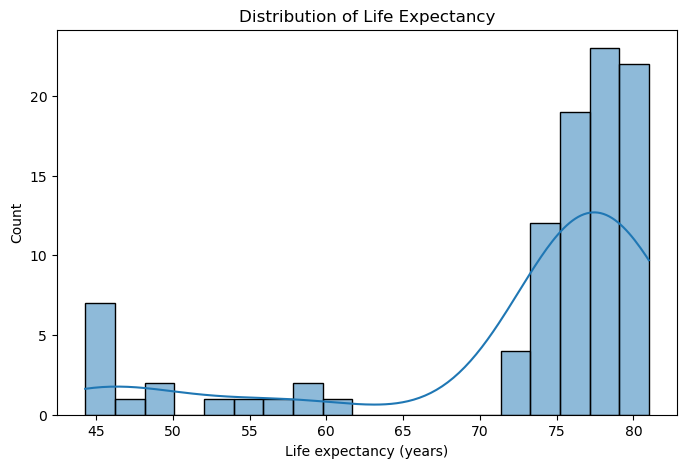

In [41]:
# Distribution of life expectancy
plt.figure(figsize=(8, 5))
sns.histplot(df["life_expectancy"], kde=True)
plt.title("Distribution of Life Expectancy")
plt.xlabel("Life expectancy (years)")
plt.ylabel("Count")
plt.savefig(FIGURES_DIR / "life_expectancy_distribution.png", bbox_inches="tight")
plt.show()

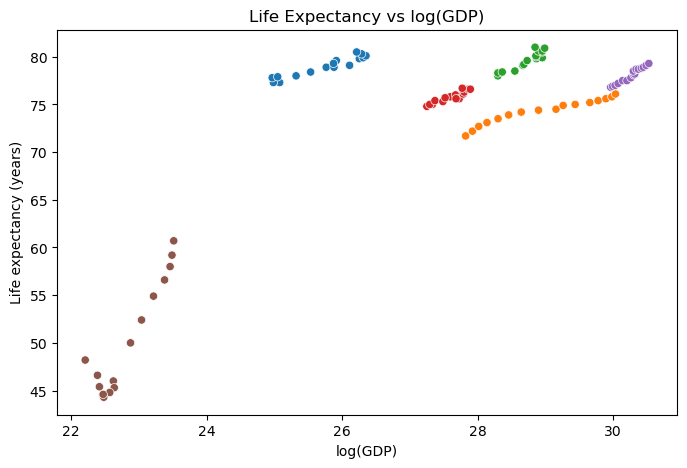

In [42]:
# Relationship between economic scale (log GDP) and life expectancy
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x="gdp_log", y="life_expectancy", hue="Country", legend=False)
plt.title("Life Expectancy vs log(GDP)")
plt.xlabel("log(GDP)")
plt.ylabel("Life expectancy (years)")
plt.savefig(FIGURES_DIR / "life_exp_vs_gdp.png", bbox_inches="tight")
plt.show()

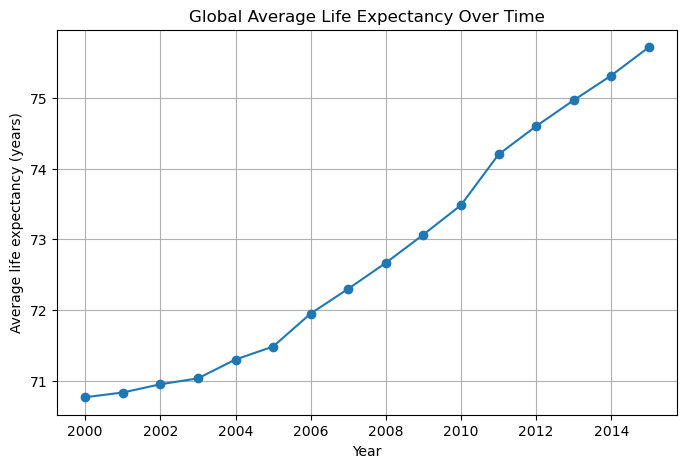

In [43]:
# Global average life expectancy over time
global_trend = df.groupby("Year")["life_expectancy"].mean().reset_index()

plt.figure(figsize=(8, 5))
plt.plot(global_trend["Year"], global_trend["life_expectancy"], marker="o")
plt.title("Global Average Life Expectancy Over Time")
plt.xlabel("Year")
plt.ylabel("Average life expectancy (years)")
plt.grid(True)
plt.savefig(FIGURES_DIR / "global_life_expectancy_trend.png", bbox_inches="tight")
plt.show()

## 5. Diagnostic Analytics with Linear Regression

Now we move beyond description and try to **explain** life expectancy using a simple linear regression model.

We model:

> `life_expectancy ~ gdp_log + year_index`

This helps answer questions like:

- How much does economic scale relate to life expectancy?  
- Are outcomes improving over time after controlling for GDP?  
- Which countries are doing *worse* than we would expect given their GDP and the year?


In [44]:
# Define features (X) and target (y)
X = df[["gdp_log", "year_index"]]
y = df["life_expectancy"]

# Train/test split to check generalization
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fit a simple linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

print("Coefficients:")
for name, coef in zip(X.columns, lin_reg.coef_):
    print(f"  {name}: {coef:.3f}")

print(f"Intercept: {lin_reg.intercept_:.3f}")
print(f"R^2 on train set: {lin_reg.score(X_train, y_train):.3f}")
print(f"R^2 on test set: {lin_reg.score(X_test, y_test):.3f}")

Coefficients:
  gdp_log: 3.487
  year_index: 0.160
Intercept: -23.584
R^2 on train set: 0.648
R^2 on test set: 0.498


In [45]:
# Use the model to compute predicted life expectancy and residuals
df["life_expectancy_pred"] = lin_reg.predict(X)
df["residual"] = df["life_expectancy"] - df["life_expectancy_pred"]

# Countries with the lowest average residuals are underperforming expectations
underperformers = (
    df.groupby("Country")["residual"]
      .mean()
      .sort_values()
      .head(10)
)

underperformers

Country
Zimbabwe                    -7.128973
United States of America    -5.079492
China                       -4.352454
Germany                      1.832603
Mexico                       1.908003
Chile                       11.553941
Name: residual, dtype: float64

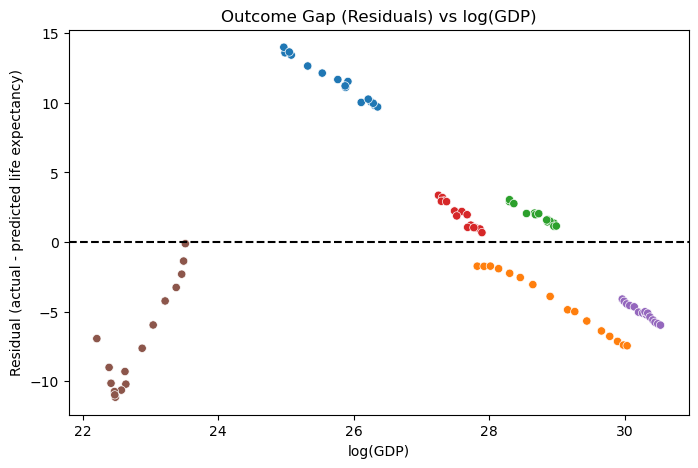

In [46]:
# Visualize residuals (outcome gap) vs economic scale
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x="gdp_log", y="residual", hue="Country", legend=False)
plt.axhline(0, color="black", linestyle="--")
plt.title("Outcome Gap (Residuals) vs log(GDP)")
plt.xlabel("log(GDP)")
plt.ylabel("Residual (actual - predicted life expectancy)")
plt.savefig(FIGURES_DIR / "outcome_gap_residuals.png", bbox_inches="tight")
plt.show()

The residual plot highlights where countries are doing better or worse than the model expects:

- Points **below** the zero line: countries with **lower** life expectancy than expected  
- Points **above** the zero line: countries with **higher** life expectancy than expected  

This is similar to finding underperforming or overperforming segments in a healthcare population.


## 6. Population Segmentation with Clustering

To make the results more actionable, we segment countries into **risk groups** using K-Means clustering based on:

- `life_expectancy`  
- `gdp_log`  

We then label the clusters from **High Risk** to **Low Risk** based on their average life expectancy.


In [47]:
# Prepare data for clustering
cluster_features = df[["life_expectancy", "gdp_log"]].copy()

scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_features)

# Fit K-Means with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(cluster_scaled)

# Profile clusters by average life expectancy
cluster_profiles = (
    df.groupby("cluster")["life_expectancy"]
      .mean()
      .sort_values()
)
cluster_profiles

cluster
2    50.093750
3    75.371429
1    78.133333
0    78.943750
Name: life_expectancy, dtype: float64

In [48]:
# Map clusters to human-readable labels based on average life expectancy
label_order = ["High Risk", "Elevated Risk", "Moderate Risk", "Low Risk"]
label_map = {cluster: label for cluster, label in zip(cluster_profiles.index, label_order)}

df["cluster_label"] = df["cluster"].map(label_map)

# Quick check of cluster counts
df["cluster_label"].value_counts()

cluster_label
Moderate Risk    36
Elevated Risk    28
Low Risk         16
High Risk        16
Name: count, dtype: int64

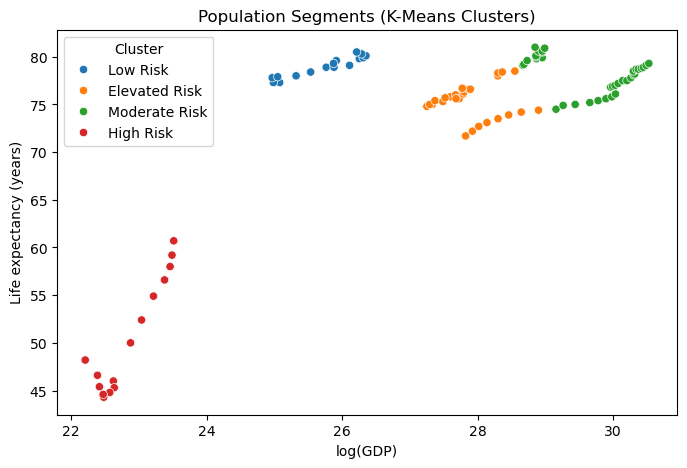

In [49]:
# Visualize clusters in log(GDP) vs life expectancy space
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=df,
    x="gdp_log",
    y="life_expectancy",
    hue="cluster_label"
)
plt.title("Population Segments (K-Means Clusters)")
plt.xlabel("log(GDP)")
plt.ylabel("Life expectancy (years)")
plt.legend(title="Cluster")
plt.savefig(FIGURES_DIR / "population_segments_clusters.png", bbox_inches="tight")
plt.show()

These segments act like **risk strata**:

- **High Risk** – lowest life expectancy and limited resources  
- **Elevated Risk** – outcomes improving but still below global averages  
- **Moderate Risk** – mid-range performance  
- **Low Risk** – highest life expectancy and strongest economic capacity  

In a healthcare setting, similar segmentation is used to prioritize care management or resource allocation.


## 7. Scenario Simulation ("What-If" Analysis)

Finally, we use the regression model to simulate a simple intervention scenario.

For a given country and year, we ask:

> *If economic resources (GDP) increased by 10%, how much would predicted life expectancy change according to the model?*

This is not a causal model, but it provides a way to reason about **sensitivity** and potential impact.


In [50]:
def simulate_life_expectancy_change(gdp_current: float,
                                   year_index: int,
                                   delta_gdp_pct: float,
                                   model: LinearRegression) -> tuple[float, float, float]:
    """
    Simulate the change in predicted life expectancy given a percentage
    increase in GDP, using the fitted linear regression model.
    """
    gdp_new = gdp_current * (1 + delta_gdp_pct / 100)

    X_current = pd.DataFrame({"gdp_log": [np.log(gdp_current)], "year_index": [year_index]})
    X_new = pd.DataFrame({"gdp_log": [np.log(gdp_new)], "year_index": [year_index]})

    y_current = model.predict(X_current)[0]
    y_new = model.predict(X_new)[0]

    return y_current, y_new, y_new - y_current

In [51]:
# Pick an example country and year to simulate
example_row = df.iloc[0]

example_country = example_row["Country"]
example_year = example_row["Year"]
example_gdp = example_row["gdp"]
example_year_index = example_row["year_index"]

y_curr, y_new, delta_y = simulate_life_expectancy_change(
    gdp_current=example_gdp,
    year_index=example_year_index,
    delta_gdp_pct=10,
    model=lin_reg
)

print(f"Country: {example_country}")
print(f"Year: {example_year}")
print(f"Baseline predicted life expectancy: {y_curr:.2f} years")
print(f"After 10% GDP increase (model-based): {y_new:.2f} years")
print(f"Change in predicted life expectancy: {delta_y:.2f} years")

Country: Chile
Year: 2000
Baseline predicted life expectancy: 63.87 years
After 10% GDP increase (model-based): 64.20 years
Change in predicted life expectancy: 0.33 years


## 8. Takeaways & Next Steps

### Key Takeaways

- There is a substantial gap in life expectancy across countries, highlighting meaningful global health disparities.  
- Economic capacity (log-transformed GDP) and time trends explain a large share of variation in life expectancy in this simple model.  
- Residual analysis helps identify countries underperforming relative to expectations, which can guide targeted intervention efforts.  
- Clustering creates interpretable risk segments (High / Elevated / Moderate / Low Risk) that mirror common population health stratification approaches.  
- Scenario simulation demonstrates how this type of modeling can support **"what-if" reasoning** about potential interventions, even if it is not strictly causal.

### Possible Extensions

- Incorporate additional features (e.g., region, health expenditure, demographics) if available.  
- Use more flexible models (e.g., regularized regression) and compare performance.  
- Build a Tableau dashboard that surfaces:
  - KPIs (average life expectancy, gaps, trends)  
  - Outcome gaps and underperformers  
  - Cluster segmentation and risk tiers  
  - Scenario-based visuals for different intervention assumptions.  

This notebook is designed to be **beginner-to-intermediate friendly**, while still reflecting the structure and thought process of real-world healthcare analytics work.
